In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from os import path
import scipy.sparse.linalg
import scipy as sp 
from skimage.segmentation import find_boundaries
import scipy.signal
import scipy.linalg
import scipy.sparse
import pyamg
from PIL import Image   

In [2]:
def display_images(source_path,target_path,mask_path):
    source = cv2.imread(source_path) 
    target = cv2.imread(target_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) 

    fig, axes = plt.subplots(1, 3, figsize=(15, 5)) 
    axes[0].imshow(source[:,:,::-1])  
    axes[0].set_title('Source')
    axes[0].axis('off')

    axes[1].imshow(target[:,:,::-1])  
    axes[1].set_title('Target')
    axes[1].axis('off')

    axes[2].imshow(mask, cmap='gray') 
    axes[2].set_title('Mask')
    axes[2].axis('off')

    plt.show()

In [3]:
def cut_paste_alpha_blend(img_dist,img_src,mask,kernel = (1,1)):
    # Convert the images to float32
    img1_float = img_dist.astype(float)
    img2_float = img_src.astype(float)

    # Smoothen and Normalize the mask
    mask = cv2.blur(mask, kernel)
    mask = mask.astype(np.float32) / 255.0

    image = mask*img2_float + (1-mask)*img1_float
    image = image.astype(np.uint8)

    return image, mask


In [4]:
def resize_shape(img, depth):
    new_shape = (img.shape[1] & ~(2**(depth-1)-1), img.shape[0] & ~(2**(depth-1)-1))
    return  cv2.resize(img, new_shape)


In [5]:
def build_gaussian_pyramid(img, depth):
    pyramid = [img]
    for i in range(depth-1):
        img = cv2.pyrDown(img)
        pyramid.append(img.astype(np.uint8))
    return pyramid

In [6]:
def build_laplacian_pyramid(gaussian_pyramid, depth):
    laplacian_pyramid = [gaussian_pyramid[-1]]
    for i in range(depth-1, 0, -1):
        gaussian_expanded = cv2.pyrUp(gaussian_pyramid[i])
        laplacian = cv2.subtract(gaussian_pyramid[i-1], gaussian_expanded)
        laplacian_pyramid.append(laplacian.astype(np.uint8))
        
    return laplacian_pyramid

In [7]:
def reconstruct_img(blended_pyramid):
    img = blended_pyramid[0]
    for i in range(1,len(blended_pyramid)):
        img = cv2.pyrUp(img)
        img = cv2.add(img, blended_pyramid[i])
    return img

In [8]:
def MultiBandBlending(img1,img2,mask,depth):
    img1 = resize_shape(img1, depth)
    img2 = resize_shape(img2, depth)
    mask = resize_shape(mask, depth)
    
    # Build the Gaussian pyramids
    gaussian_pyramid1 = build_gaussian_pyramid(img1, depth)
    gaussian_pyramid2 = build_gaussian_pyramid(img2, depth)
    mask_gaussian_pyramid = build_gaussian_pyramid(mask, depth)

    # Build the Laplacian pyramids
    laplacian_pyramid1 = build_laplacian_pyramid(gaussian_pyramid1, depth)
    laplacian_pyramid2 = build_laplacian_pyramid(gaussian_pyramid2, depth)


    # Blend the images
    blended_pyramid = []
    for i in range(depth-1,-1,-1):
        mask_gaussian  = mask_gaussian_pyramid[i]/255
        mask_gaussian = mask_gaussian / np.max(mask_gaussian)
        im1 = laplacian_pyramid1[depth-i-1].astype(float)
        im2 = laplacian_pyramid2[depth-i-1].astype(float)
        k1 = np.multiply(im1, mask_gaussian).astype(np.uint8)
        k2 = np.multiply((1-mask_gaussian), im2).astype(np.uint8)
        level_blend = k1.astype(np.uint8) + k2.astype(np.uint8)
        blended_pyramid.append(level_blend.astype(np.uint8))


    blended_image = reconstruct_img(blended_pyramid)
    
    return blended_image
        

In [9]:
def process_mask(mask):
    boundary = find_boundaries(mask, mode="inner").astype(int)
    inner = mask - boundary
    return inner, boundary

In [10]:
def get_pixel_ids(img):
    pixel_ids = np.arange(img.shape[0] * img.shape[1]).reshape(img.shape[0], img.shape[1])
    return pixel_ids

In [11]:
def get_masked_values(values, mask):
    assert values.shape == mask.shape
    nonzero_idx = np.nonzero(mask) # get mask 1
    return values[nonzero_idx]

In [12]:
def get_alpha_blended_img(src, target, alpha_mask):
    return src * alpha_mask + target * (1 - alpha_mask)

In [13]:
def construct_A_matrix(img_w,mask_ids,inner_ids,inner_pos,boundary_pos):
    n1_pos = np.searchsorted(mask_ids, inner_ids - 1)
    n2_pos = np.searchsorted(mask_ids, inner_ids + 1)
    n3_pos = np.searchsorted(mask_ids, inner_ids - img_w)
    n4_pos = np.searchsorted(mask_ids, inner_ids + img_w)

    A = scipy.sparse.lil_matrix((len(mask_ids), len(mask_ids)))
    A[inner_pos, n1_pos] = 1
    A[inner_pos, n2_pos] = 1
    A[inner_pos, n3_pos] = 1
    A[inner_pos, n4_pos] = 1
    A[inner_pos, inner_pos] = -4 
    A[boundary_pos, boundary_pos] = 1
    A = A.tocsr()
    
    return A


In [14]:
def construct_b(mask_ids,inner_pos,boundary_pos,inner_gradient_values, boundary_pixel_values):
    b = np.zeros(len(mask_ids))
    b[inner_pos] = inner_gradient_values
    b[boundary_pos] = boundary_pixel_values
    return b

In [15]:
def compute_gradient(img, forward=True):
    if forward:
        kx = np.array([
            [0, 0, 0],
            [0, -1, 1],
            [0, 0, 0]
        ])
        ky = np.array([
            [0, 0, 0],
            [0, -1, 0],
            [0, 1, 0]
        ])
    else:
        kx = np.array([
            [0, 0, 0],
            [-1, 1, 0],
            [0, 0, 0]
        ])
        ky = np.array([
            [0, -1, 0],
            [0, 1, 0],
            [0, 0, 0]
        ])
    Gx = scipy.signal.fftconvolve(img, kx, mode="same")
    Gy = scipy.signal.fftconvolve(img, ky, mode="same")
    return Gx, Gy

In [16]:
def compute_laplacian(img):
    kernel = np.array([
        [0, 1, 0],
        [1, -4, 1],
        [0, 1, 0]
    ])
    laplacian = scipy.signal.fftconvolve(img, kernel, mode="same")
    return laplacian

In [17]:
def compute_mixed_gradients(src, target,mode, alpha):
    if mode == 'max':
        Ix_src, Iy_src = compute_gradient(src)
        Ix_target, Iy_target = compute_gradient(target)
        I_src_amp = (Ix_src**2 + Iy_src**2)**0.5
        I_target_amp = (Ix_target**2 + Iy_target**2)**0.5
        Ix = np.where(I_src_amp > I_target_amp, Ix_src, Ix_target)
        Iy = np.where(I_src_amp > I_target_amp, Iy_src, Iy_target)
        Ixx, _ = compute_gradient(Ix, forward=False)
        _, Iyy = compute_gradient(Iy, forward=False)

        return Ixx + Iyy
    elif mode == 'alpha':
        src_laplacian = compute_laplacian(src)
        target_laplacian = compute_laplacian(target)
        return alpha * src_laplacian + (1 - alpha) * target_laplacian


In [18]:
def poisson_blend_channel(src, target,mask,boundary_mask,inner_mask,solver,solver_func,mask_pos,inner_pos,boundary_pos,mask_ids,A,mode,alpha):
    mixed_gradients = compute_mixed_gradients(src, target,mode,alpha)
    boundary_pixel_values = get_masked_values(target, boundary_mask).flatten()
    inner_gradient_values = get_masked_values(mixed_gradients, inner_mask).flatten()
    # Construct b
    
    b = construct_b(mask_ids,inner_pos,boundary_pos,inner_gradient_values, boundary_pixel_values)
    # Solve Ax = b
    if solver != "multigrid":
        x = solver_func(A, b)
        if isinstance(x, tuple): # solvers other than spsolve
            x = x[0]
    else:
        # Use multigrid solver
        ml = pyamg.ruge_stuben_solver(A)
        x = ml.solve(b, tol=1e-10)
    new_src = np.zeros(src.size)
    new_src[mask_pos] = x
    new_src = new_src.reshape(src.shape)
    poisson_blended_img = get_alpha_blended_img(new_src, target, mask)
    poisson_blended_img = np.clip(poisson_blended_img, 0, 1)
    
    return poisson_blended_img

In [19]:
def poisson_blend(src,target, mask,solver,mode,alpha):

    if solver != "multigrid":
        solver_func = getattr(scipy.sparse.linalg, solver)
    else:
        solver_func = None
    mask = cv2.cvtColor(mask,  cv2.COLOR_RGB2GRAY)
    mask = mask.astype(np.float64) / 255
    if len(src.shape) == 3:
        src = src[...,: 3]
    if len(target.shape) == 3:
        target = target[...,: 3]


    src = src.astype(np.float64) / 255
    target = target.astype(np.float64) / 255

    mask_h, mask_w = mask.shape
    _, mask = cv2.threshold(mask, 0.5,1, cv2.THRESH_BINARY)
    inner_mask , boundary_mask = process_mask(mask)
    pixels_id = get_pixel_ids(mask)
    inner_ids = get_masked_values(pixels_id, inner_mask).flatten()
    boundary_ids = get_masked_values(pixels_id, boundary_mask).flatten()
    mask_ids = get_masked_values(pixels_id, mask).flatten()

    inner_pos = np.searchsorted(mask_ids, inner_ids)
    boundary_pos = np.searchsorted(mask_ids, boundary_ids)
    mask_pos = np.searchsorted(pixels_id.flatten(), mask_ids)


    A = construct_A_matrix(mask_w,mask_ids,inner_ids,inner_pos,boundary_pos)
    poisson_blended_img_rgb = []
    for i in range(src.shape[-1]):
        poisson_blended_img_rgb.append(
            poisson_blend_channel(
                src[..., i], target[..., i],mask,boundary_mask,
                inner_mask,solver,solver_func,mask_pos,inner_pos,boundary_pos,mask_ids,A,mode,alpha
            )
        )
    img = np.dstack(poisson_blended_img_rgb)
    img = (img*255).astype(np.uint8)
    return img


In [20]:
def poisson_blending(image1, image2, mask, p):
    return cv2.seamlessClone(image2, image1, mask, p, cv2.NORMAL_CLONE)

In [21]:
def perform_blending(source_path, destination_path, mask_path, blending_method,mode='max',alpha=1,p=(0,0),kernel=(1,1),depth=5,solver='spsolve'):
    # Load the input images

    src_img = np.array(Image.open(source_path))
    dest_img = np.array(Image.open(destination_path))

    mask = cv2.imread(mask_path)
    mask = cv2.cvtColor(mask,  cv2.COLOR_BGR2RGB)

    # Perform the blending

    if blending_method == 'cut_paste':
        blended_img, _ = cut_paste_alpha_blend(dest_img, src_img, mask)
    elif blending_method == 'alpha':
        blended_img, _ = cut_paste_alpha_blend(dest_img, src_img, mask,kernel)
    elif blending_method == 'multiband':
        blended_img = MultiBandBlending(src_img,dest_img, mask, depth)
    elif blending_method == 'poisson_scratch':
        blended_img = poisson_blend(src_img, dest_img, mask, solver,mode,alpha)
    elif blending_method == 'poisson':
        blended_img = poisson_blending(dest_img,src_img, mask,p)
    

    else:
        raise ValueError('Invalid blending method')

    # Display the blended image
    plt.imsave('blended_img '+blending_method+'.png', blended_img)
    plt.imshow(blended_img)
    plt.show()  

In [44]:
dir = 'D:/PDFs/4th year-2nd sem/CV/project/blending_stiching/test/'
source_path = path.join(dir, "source.png")
destination_path = path.join(dir, "target.png")
mask_path = path.join(dir, "mask.png")

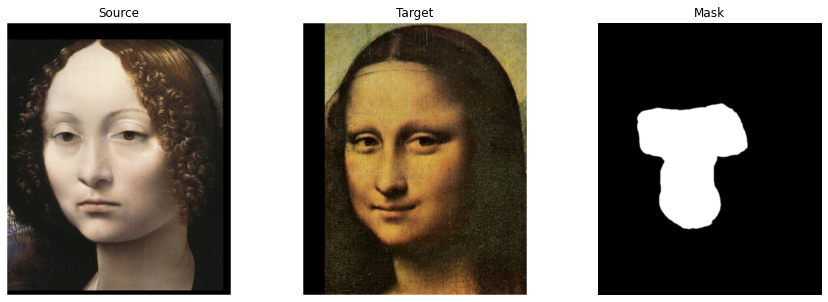

In [45]:
display_images(source_path,destination_path,mask_path)

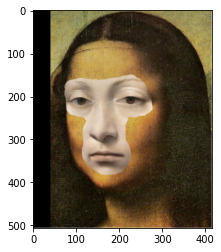

In [46]:
blending_method = 'cut_paste' 
perform_blending(source_path,destination_path, mask_path,blending_method)

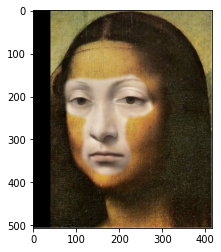

In [47]:
blending_method = 'alpha' 
kernel = (9,9)
perform_blending(source_path,destination_path, mask_path, blending_method,kernel = kernel)

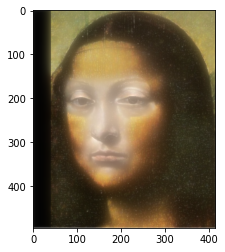

In [48]:
blending_method = 'multiband' 
depth = 6
perform_blending(source_path,destination_path, mask_path, blending_method)

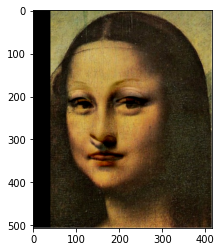

In [49]:
blending_method = 'poisson_scratch' 
solver = 'spsolve'
mode = 'max'
perform_blending(source_path,destination_path, mask_path, blending_method,mode=mode,solver=solver)

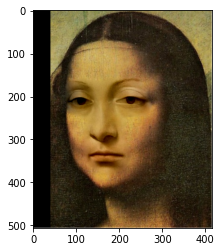

In [50]:
blending_method = 'poisson_scratch' 
solver = 'spsolve'
mode = 'alpha'
alpha = 1
perform_blending(source_path,destination_path, mask_path, blending_method,mode=mode,alpha=alpha,solver=solver)

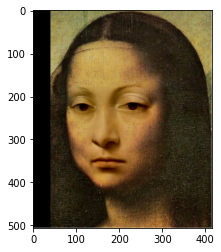

In [52]:
blending_method = 'poisson' 
p = 180,280
perform_blending(source_path,destination_path, mask_path, blending_method,p=p)

#### Poisson Color Transfer

In [34]:
def nearby(i, j, max_i, max_j):
    pairs = []
    
    for n in [-1, 1]:
        if 0 <= i+n <= max_i:
            pairs.append((i+n, j))
        if 0 <= j+n <= max_j:
            pairs.append((i, j+n))
    
    return pairs

In [35]:
def color_transfer(img_s, img_t,alpha):
    
    img_t_h, img_t_w = img_t.shape[:2]
        
    im2var = np.arange(img_t_h * img_t_w * 3).reshape((img_t_h, img_t_w, 3)) 
    
    A = sp.sparse.lil_matrix((img_t_h*img_t_w*3*5, img_t_h*img_t_w*3))
    b = np.zeros(img_t_h*img_t_w*3*5)
    
    e = 0
    for n in range(3):
        img_s_channel_avg = np.mean(img_s[:,:,n])
        img_s_channel_std = np.std(img_s[:,:,n])
        img_t_channel_avg = np.mean(img_t[:,:,n])
        img_t_channel_std = np.std(img_t[:,:,n])
        
        for y in range(img_t_h):
            for x in range(img_t_w):
                A[e, im2var[y][x][n]] = 1

                b[e] = img_t[y][x][n] - (img_t_channel_avg * (img_t_channel_std / img_s_channel_std) - img_s_channel_avg) * alpha
                e += 1
                
                for n_y, n_x in nearby(y, x, img_t_h-1, img_t_w-1):
                    A[e, im2var[y][x][n]] = 1
                    A[e, im2var[n_y][n_x][n]] = -1
                    b[e] = img_t[y][x][n] - img_t[n_y][n_x][n]
                    e += 1
    
    A = sp.sparse.csr_matrix(A)
    v = sp.sparse.linalg.lsqr(A, b)[0]
      
    return np.clip(v.reshape((img_t_h, img_t_w, 3)), 0, 1)

In [36]:
src_img = np.array(Image.open('D:/PDFs/4th year-2nd sem/CV/project/blending_stiching/test/source.png'))
dest_img = np.array(Image.open("D:/PDFs/4th year-2nd sem/CV/project/blending_stiching/test/target.png"))

In [37]:
alpha = 0.5

colored_img = color_transfer(dest_img,src_img ,alpha)

D:\softwares\Scripts\singh\AppData\Local\Temp\ipykernel_23332\916879586.py:27: RuntimeWarning: overflow encountered in scalar subtract
  b[e] = img_t[y][x][n] - img_t[n_y][n_x][n]


In [38]:
def show_images(
    imgs, titles, figsize) :
    idx = 1
    fig = plt.figure(figsize=figsize)

    for img, title in zip(imgs, titles):
        ax = fig.add_subplot(1, len(imgs), idx)
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel(title)
        idx += 1
    plt.show()

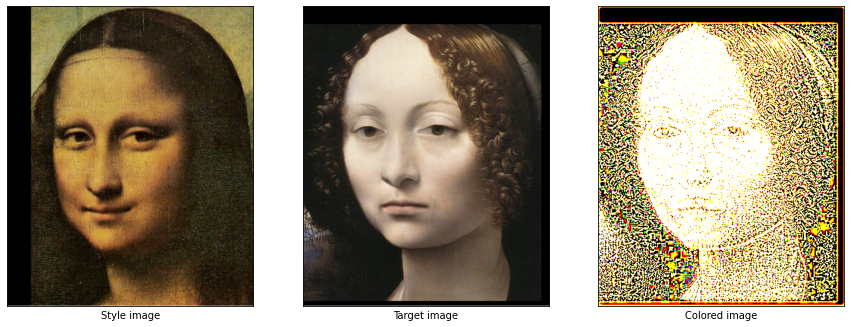

In [39]:
show_images(
    [dest_img,src_img, colored_img], 
    ["Style image", "Target image", "Colored image"], 
    figsize=(15, 8)
)